In [10]:
import numpy as np

from IPython.display import Image, display


# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../') # Add the course directory to the Python path
import cphy.plotting as cplot



# Models with latent variables

+ Gaussian mixture models(unsupervised model)
+ Clustering (unsupervised)
+ Unsupervised learning: we want to learn the underlying structure of the data


## Bayes' Theorem and Maximum-Likelihood


If $X$ denotes our observed data, and $\theta$ denotes the parameters of our model of the data's generating process,
$$
p(X | \theta)\, p(\theta) = p(\theta |X)\, p(X)
$$
The individual terms in Bayes' theorem have distinct interpretations. 

+ The distribution over model parameters, $p(\theta)$, represents the *prior*; in the absence of any observed data, the prior tells us our expectation regarding the model values. This distribution might incorporate domain knowledge or previous fitted models.
+  The distribution $p(X)$ represents the distribution of observable data, which depends on factors external to the model.
+  The conditional probability $p(\theta | X)$ represents the *posterior* of the model: given our observations, $X$, the posterior determines the probability of different models. 
+ The conditional probability $p(X | \theta)$ represents the *likelihood*, which is the probability of having observed a given set of observations $X$ given a specific model with parameters $\theta$. 

Many classes of algorithms attempt to determine $\theta$ through *maximumum likelihood methods,* which attempt to find the model $\theta$ that maximizes the probability of the observed dats $X$.


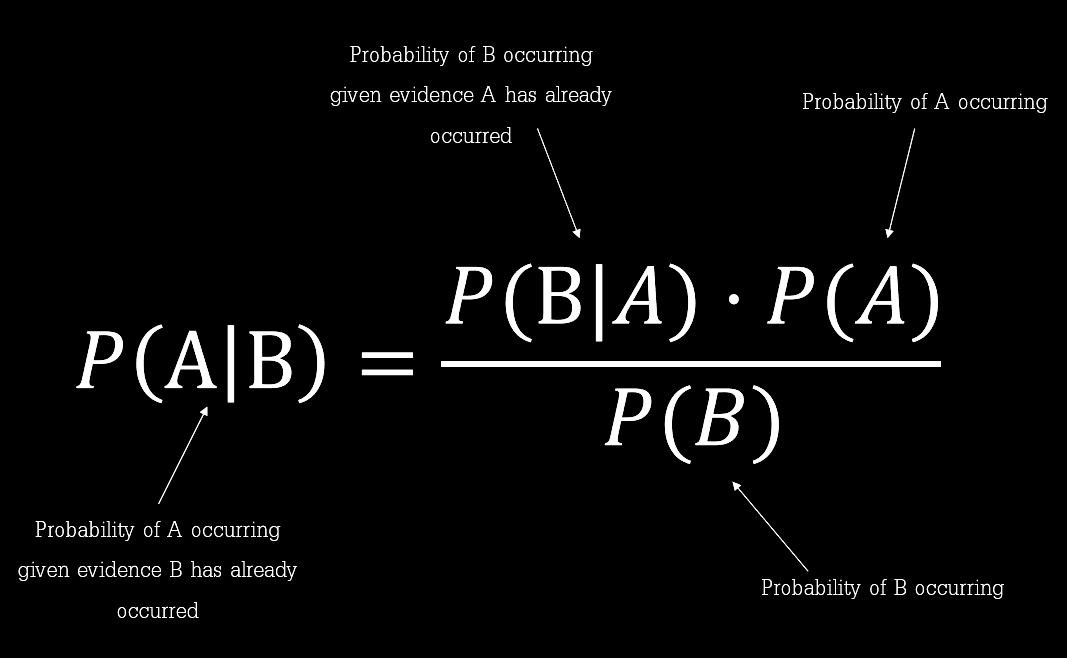

In [295]:
Image("../resources/bayes.png", width=600)
# https://thestatsninja.com/2019/03/03/how-to-decipher-false-positives-and-negatives-with-bayes-theorem/

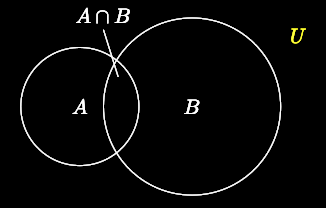

In [296]:
# show two images
Image("../resources/bayes_overlap.png", width=600)
# https://towardsdatascience.com/3-ways-to-think-about-bayes-rule-b6f5b4ef87d6

## EM algorithm

+ For learning generative models with latent variables in cases where we don't have gradient information to perform traditional optimization. For example, we have data that we suspect has been sampled from a family of probability distributions. The sampling itself is a non-invertible and non-differentiable process
+ Common ML methods that use the EM algorithm are: hidden Markov models, clustering, and mixture models

Broadly, the EM algorithm has two steps: 
1. *Expectation.* We create an initial estimate for the parameters $\theta$, and we then calculate the posterior probability different datapoints under the initial model, $p(X | \theta)$. These values are sometimes called the "responsibilities." 
2. *Maximization.* We update our estimate of $\theta$ in order to maximize the likelihood of the training dataset.

For more discussion of the EM algorithm, Gaussian mixtures, and clustering, see section 2.1 of [this paper](https://arxiv.org/pdf/1111.0352.pdf)
<!-- https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95? -->

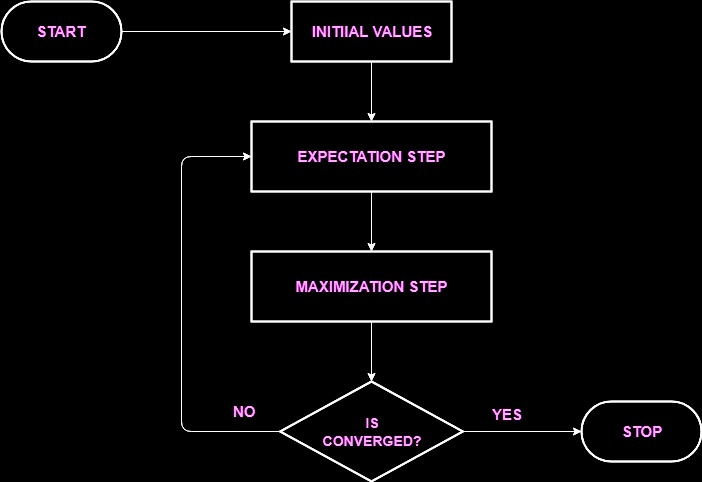

In [289]:
Image("../resources/em_algo.jpeg")
# Source: https://www.geeksforgeeks.org/ml-expectation-maximization-algorithm

## Superresolution: localizing emitters in blurry images

+ Superresolution microscopy involves using chemical or computational methods to image systems in visible light below the classical diffraction limit. This can be useful for studying chemical and biological systems (which are often probed using fluorophores that emit visible fluorescence), but similar methods have been adapted for other wavelengths and imaging modalities.
+ In superresolution microscopy, we attempt to beat the diffraction limit by localizing the emitter of individual photons. This can be done by exploiting temporal information---for example, if an emission site only intermittently releases photons, we can average their positions. 
+ For example, if the point spread function of a point source is a Gaussian, we want to localize the emitter to the mean of the Gaussian. 
+ In some advanced superresolution methods, like PALM/STORM, only a subset of all fluorescent sources are activated at a given time, thus reducing the likelihood of two sources overlapping and thereby improving centroid localization
+ Here, we are going to work with a fluorescence microscopy image where we assume that we have a gaussian point spread function. We are going to fit the image to a mixture of Gaussians, in order to gain information about the subpixel features.
+ The image below shows the edge of a cell's nuclear envelope, where genetic material (chromatin) has been stained in blue, nuclear pores in red, and the envelope itself in green.

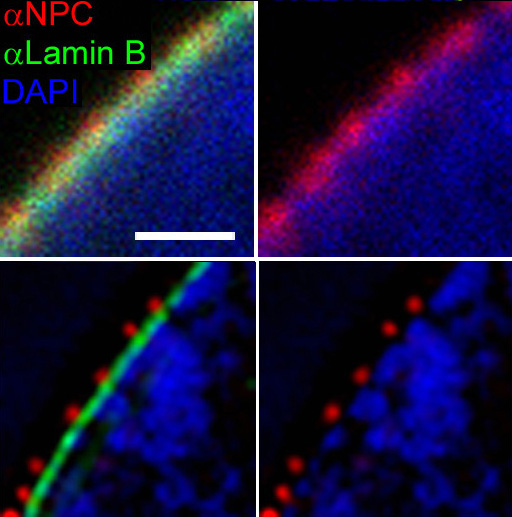

In [11]:
from PIL import Image
im_path = "../resources/wikimedia_3D-SIM-1_NPC_Confocal_vs_3D-SIM_detail.jpg"
# Open the image form working directory
im = Image.open(im_path)
im

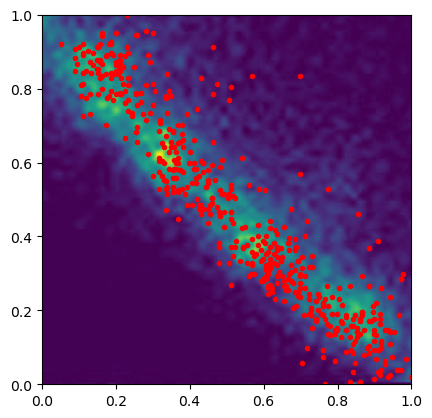

In [12]:
## Let's excerpt the red channel
im_excerpt = np.array(im)[:210, -225:-20, 0]
plt.figure()
plt.imshow(im_excerpt, extent=[0, 1, 0, 1], origin='lower')


## Sample data from the image---photons, counts, etc.
im_excerpt = im_excerpt / np.sum(im_excerpt)
im_excerpt = im_excerpt ** 2
im_excerpt = im_excerpt / np.sum(im_excerpt)
np.random.seed(0)
index = np.random.choice(np.prod(im_excerpt.shape), size=500, p=im_excerpt.ravel())
X = np.array(np.unravel_index(index, shape=im_excerpt.shape)).T.astype(float)
X /= X.max(axis=0) # scale to unit square

plt.plot(X[:, 0], X[:, 1], '.r')

# ## Let's try to fit a Gaussian mixture model to this data
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=4, covariance_type='full')
# gmm.fit(X)

# ## Let's plot the results
# plt.plot(gmm.means_[:, 0], gmm.means_[:, 1], '*w', markersize=20)

In [13]:
from scipy.stats import multivariate_normal

class GaussianMixtureModel:
    """
    An implementation of the EM algorithm for Gaussian mixture models.

    Attributes:
        n_components (int): The number of mixture components.
        n_iter (int): The number of EM iterations to perform.
        tol (float): The convergence threshold. EM iterations will stop when the
            log likelihood average gain is below this threshold.
        store_history (bool): Whether or not to store the history of the means
            at each step.
        learning_rate (float): The learning rate for the gradient descent update.
        random_state (int): The random seed.

    """

    def __init__(self, n_components, n_iter=100, tol=1e-6, store_history=False, 
                    learning_rate=1.0, random_state=None
                ):
        self.n_components = n_components
        self.n_iter = n_iter
        self.tol = tol
        self.learning_rate = learning_rate

        self.random_state = random_state

        self.store_history = store_history
        if self.store_history:
            self.history = list()
    
    ## This special method determines the output of print(GaussianMixtureModel())
    def __str__(self):
        return "GaussianMixtureModel(n_components={})".format(self.n_components)

    def initialize(self, X):
        """Initialize the GMM parameters.

        Parameters:
            X (array-like): Training data with shape (n_samples, n_features)
            
        Returns:
            self
        """
        n_samples, n_features = X.shape

        np.random.seed(self.random_state)

        # Initialize the weights to equal
        self.weights = np.ones(self.n_components) / self.n_components

        # Initialize the means randomly from the data
        self.means = np.random.choice(X.flatten(), size=(self.n_components, n_features))
        #self.means = np.random.random(size=(self.n_components, n_features)) * np.ptp(X, axis=0)

        # Initialize the covariances
        self.covariances = np.zeros((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            self.covariances[k] = np.diag(np.random.rand(n_features))

        return self

    def pdf(self, X):
        """Compute the probability density function for each sample in X.

        Parameters:
            X (array-like): Training data with shape (n_samples, n_features)

        Returns:
            pdf (array-like): Probability density function for each sample in X.
        """
        n_samples, n_features = X.shape

        pdf = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            pdf[:, k] = self.weights[k] * multivariate_normal.pdf(X, self.means[k], self.covariances[k])

        return pdf

    def expectation(self, X):
        """Perform the expectation step.

        Parameters:
            X (array-like): Training data with shape (n_samples, n_features)

        Returns:
            responsibilities (array-like): The responsibilities for each sample in X.
        """
        pdf = self.pdf(X)
        responsibilities = pdf / pdf.sum(axis=1, keepdims=True)

        return responsibilities

    def maximization(self, X, responsibilities):
        """Perform the maximization step.

        Parameters:
            X (array-like): Training data with shape (n_samples, n_features)
            responsibilities (array-like): The responsibilities for each sample in X.
                
        Returns:
            self
        """
        n_samples, n_features = X.shape

        # Update the weights
        self.weights = responsibilities.sum(axis=0) / n_samples

        # Update the means
        self.means = (1 - self.learning_rate) * self.means + self.learning_rate * np.dot(responsibilities.T, X) / responsibilities.sum(axis=0, keepdims=True).T

        #self.means_new = (1 - beta) * self.means_old + beta * self.means_new

        # Update the covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covariances[k] = (1 - self.learning_rate) * self.covariances[k] + self.learning_rate * np.dot(responsibilities[:, k] * diff.T, diff) / responsibilities[:, k].sum()

        return self

    def fit(self, X):
        """Fit the model to the data X.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Data.

        Returns
        -------
        self
        """
        self.initialize(X)

        for i in range(self.n_iter):
            # Expectation step
            responsibilities = self.expectation(X)

            # Maximization step
            self.maximization(X, responsibilities)

            # store the history
            if self.store_history:
                self.history.append(self.means.copy())

        return self

    def predict(self, X):
        """Predict the labels for X.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Data.

        Returns
        -------
        labels : array-like, shape (n_samples,)
            Predicted labels for each sample in X.
        """
        return self.expectation(X).argmax(axis=1)






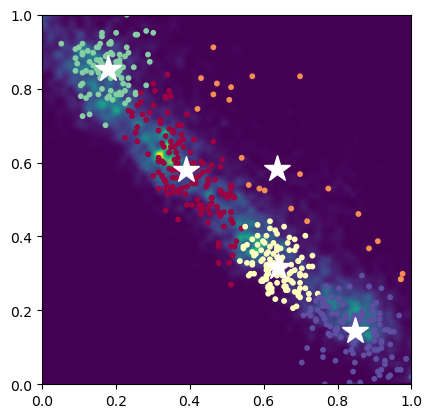

In [14]:
gmm = GaussianMixtureModel(n_components=5, n_iter=2000, learning_rate=0.5, store_history=True, random_state=0)
gmm.fit(X)
labels = gmm.predict(X)

plt.imshow(im_excerpt, extent=[0, 1, 0, 1], origin='lower')
cmap = plt.cm.get_cmap('Spectral')
clrs = cmap(labels / np.max(labels))
plt.scatter(X[:, 0], X[:, 1], c=clrs, s=10)

# Plot centroids
plt.plot(gmm.means[:, 0], gmm.means[:, 1], '*w', markersize=20)

In [19]:
%matplotlib inline
import numpy as np
import scipy.signal
import matplotlib.pylab as plt
import matplotlib.animation
import IPython.display

def update(i):
    # global A, img
    # U = scipy.signal.convolve2d(A, K, mode='same', boundary='wrap')
    # A = np.clip(A + 1/T * growth(U), 0, 1)
    # img.set_array(A)
    # return img,
    return im_excerpt
# figure_asset(K, growth, bar_K=True)
# fig = figure_world(A)
fig = plt.figure(figsize=(6, 6))
IPython.display.HTML(matplotlib.animation.FuncAnimation(fig, update, frames=200, interval=20).to_jshtml())

<Figure size 600x600 with 0 Axes>

In [15]:
## Make an interactive video
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(im_excerpt, extent=[0, 1, 0, 1], origin='lower')
    plt.plot(gmm.history[i][:, 0], gmm.history[i][:, 1], '*w', markersize=20)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()


interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(gmm.history) - 1, 1, layout=Layout(width='800px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='800px'), max=1999), Output()), …

<function __main__.plotter(i)>

# Super-resolution microscopy: PALM and STORM

+ Major advances in biological imaging have been achieved by localizing the centroid of the blurry signal emitted by single fluorescent emitters. While a fluorescence image itself may be diffraction-limited, the inferred centroid uses statistical assumptions to achieve a resolution beyond the diffraction limit. 

+ This concept underlies super-resolution microscopy, which won the 2014 Nobel Prize in Chemistry in 2014.

+ In PALM (photo-activated localization microscopy) and STORM (stochastic optical reconstruction microscopy), the sample is stained with a photo-switchable fluorescent dye. The dye is activated by a laser pulse, and the centroid of the resulting fluorescence may be localized with Bayesian methods. The dye is then deactivated, and the process is repeated.

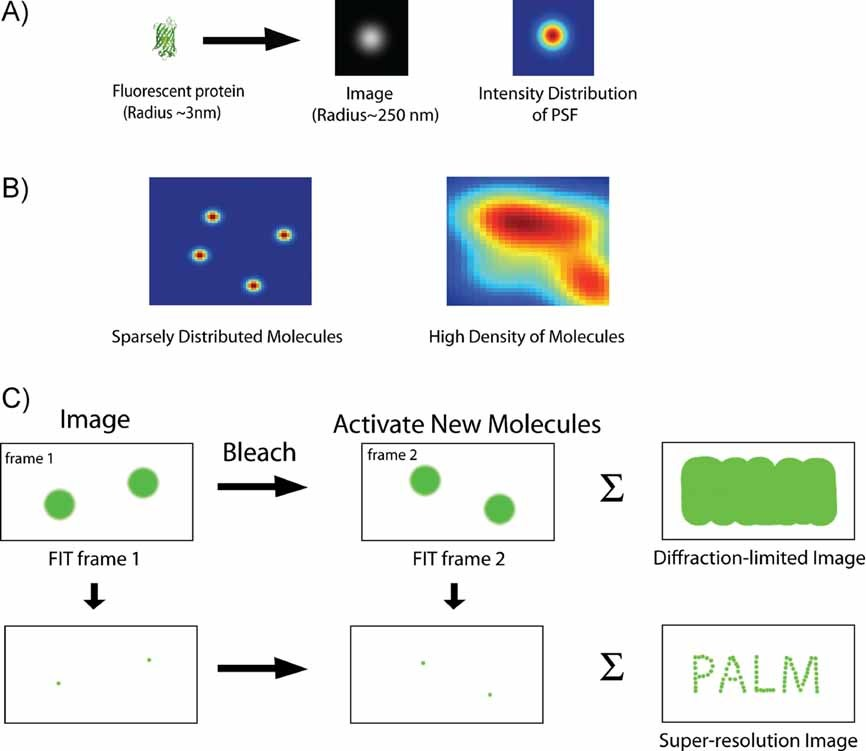

In [21]:
Image("../resources/palm_storm.jpg", width=750)
# Sengupta & Lippincott-Schwartz, Bioessays 2012
# https://doi.org/10.1002/bies.201200022

In [22]:
fpath = "/Users/william/Downloads/DeepSTORM dataset_v1/BIN10_glia_actin_2D.tif"

# open 3d tiff file

import imageio

img = imageio.imread(fpath)
cplot.sliderplot(img[::5][:100], cmap='gray')


ModuleNotFoundError: No module named 'imageio'

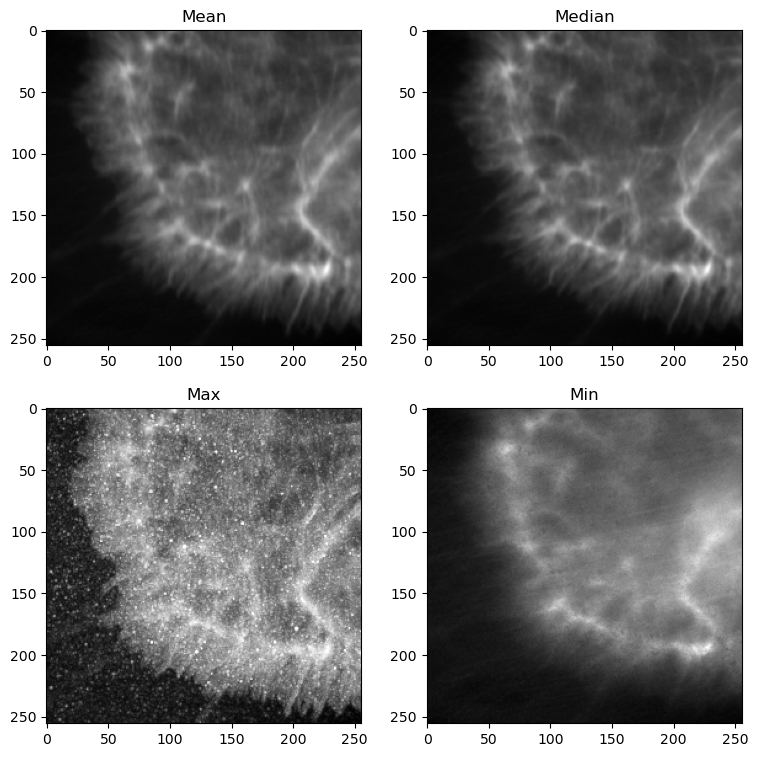

In [35]:

# Display many "naive" ways of combining the images as an array of plots

plt.figure(figsize=(9, 9))
plt.subplot(2, 2, 1)
plt.imshow(np.mean(img, axis=0), cmap='gray')
plt.title('Mean')
plt.subplot(2, 2, 2)
plt.imshow(np.median(img, axis=0), cmap='gray')
plt.title('Median')
plt.subplot(2, 2, 3)
plt.imshow(np.max(img, axis=0), cmap='gray')
plt.title('Max')
plt.subplot(2, 2, 4)
plt.imshow(np.min(img, axis=0), cmap='gray')
plt.title('Min')
plt.show()


In [62]:
# perform subpixel localization using Gaussian Mixture Model
# using maximum likelihood estimation and expectation maximization

import numpy as np
from sklearn.mixture import GaussianMixture
    

def gmm_mle_em_2d(data, n_components=1, max_iter=100, tol=1e-3, verbose=False):
    """
    Perform subpixel localization using Gaussian Mixture Model with maximum likelihood
    estimation and expectation maximization.

    Args:
        data (ndarray): the data to fit
        n_components (int): the number of components to fit
        max_iter (int): the maximum number of iterations
        tol (float): the tolerance
        verbose (bool): whether to print the log likelihood at each iteration

    Returns:
        centers (ndarray): the centers of the fitted components
        covariances (ndarray): the covariances of the fitted components
        weights (ndarray): the weights of the fitted components

    """
    gmm = GaussianMixture(
        n_components=n_components, max_iter=max_iter, tol=tol, verbose=verbose
    )
    gmm.fit(data)
    centers = gmm.means_
    covariances = gmm.covariances_
    weights = gmm.weights_
    return centers, covariances, weights

# apply localization to bright spots in one image stored in the variable img

# first, find the bright spots
# from skimage.feature import peak_local_max
# from skimage.filters import threshold_otsu

# use sklearn to find Otsu threshold
from sklearn.cluster import KMeans

all_centers = list()

for i, im in enumerate(img[::20][:100]):
    if i % 10 == 0:
        print(i, flush=True)
    # flatten the image
    # use k-means to find the threshold
    kmeans = KMeans(n_clusters=2).fit(im.reshape(-1, 1))
    thresh = np.mean(kmeans.cluster_centers_)

    # find peaks above the threshold using sklearn and numpy
    peaks = np.array(np.where(img[0] > thresh)).T

    # fit the data
    centers, covariances, weights = gmm_mle_em_2d(peaks, n_components=20)

    # plot the results
    # from cphy.plotting import plt_sphere

    all_centers.append(centers)

all_centers = np.array(all_centers)

# # plot the image
# plt.imshow(img[0], cmap='gray')
# # plot the centers
# plt.scatter(centers[:, 1], centers[:, 0], marker='x', color='r')

0
10
20
30
40
50
60
70
80
90


In [ ]:
# we can accelerate this calculation using MLE to "batch" images together

In [71]:
#from scipy.stats import multivariate_normal
# import gaussian



reconstructed_image = np.zeros_like(img[0])
for centers in all_centers:
    for center in centers:
        reconstructed_image += gaussian(center, 1, img[0].shape)
        # reconstructed_image[center[0], center[1]] = 1



LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

In [69]:
center

array([138.0838126 , 154.60201996])

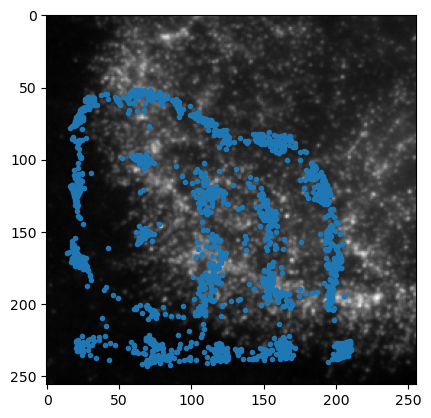

In [66]:
plt.imshow(img[0], cmap='gray')
plt.plot(all_centers[..., 0].ravel(), all_centers[..., 1].ravel(), '.')



In [4]:
fpath = "/Users/william/Downloads/example_data/T_lwm_data.mat"

from scipy.io import loadmat

data = loadmat(fpath)

In [9]:
data["__function_workspace__"]

array([[ 0,  1, 73, ...,  0,  0,  0]], dtype=uint8)

In [ ]:

class QuadtreeNode:
    def __init__(self, bounds, particles=None):
        self.bounds = bounds  # (x_min, y_min, x_max, y_max)
        self.particles = particles or []
        self.children = [None, None, None, None]  # Pointers to child nodes

    

class FastMultipoleMethod:
    """
    Simulate an N-body gravitial system using the Fast Multipole Method (FMM). Assume
    that the particles are point masses with equal sizes
    
    """

    def __init__(self, n_particles=100, n_steps=100, dt=0.01, random_state=None):
        self.n_particles = n_particles
        self.n_steps = n_steps
        self.dt = dt
        self.random_state = random_state
        self._init_particles()

    def _init_particles(self):
        """
        Initialize the particles in the simulation
        """
        np.random.seed(self.random_state)
        self.masses = np.ones(self.n_particles)
        self.positions = np.random.randn(self.n_particles, 3)
        self.velocities = np.random.randn(self.n_particles, 3)

    def _compute_accelerations(self):
        """
        Compute the accelerations of the particles
        """
        self.accelerations = np.zeros_like(self.positions)
        for i in range(self.n_particles):
            for j in range(self.n_particles):
                if i != j:
                    r = self.positions[i] - self.positions[j]
                    self.accelerations[i] += -r / np.linalg.norm(r) ** 3

    def _compute_potential(self):
        """
        Compute the potential energy of the system
        """
        self.potential = 0
        for i in range(self.n_particles):
            for j in range(self.n_particles):
                if i != j:
                    r = self.positions[i] - self.positions[j]
                    self.potential += -1 / np.linalg.norm(r)

    def _compute_kinetic(self):
        """
        Compute the kinetic energy of the system
        """
        self.kinetic = 0.5 * np.sum(self.velocities ** 2)

    def _compute_energy(self):
        """
        Compute the total energy of the system
        """
        self._compute_potential()
        self._compute_kinetic()
        self.energy = self.potential + self.kinetic

    def _compute_forces(self):
        """
        Compute the forces on the particles
        """
        self.forces = np.zeros_like(self.positions)
        for i in range(self.n_particles):
            for j in range(self.n_particles):
                if i != j:
                    r = self.positions[i] - self.positions[j]
                    self.forces[i] += -r / np.linalg.norm(r) ** 3

def build_tree(self):
    # Define the bounds of the root node (you may customize this based on your system)
    root_bounds = (0, 0, self.domain_size_x, self.domain_size_y)
    # Create the root node
    root = QuadtreeNode(root_bounds, self.particles)
    # Recursively build the tree starting from the root
    self._build_tree_recursive(root, self.max_depth)

def _build_tree_recursive(self, node, depth):
    # Base case: if the node has only one particle or reached the max depth
    if len(node.particles) <= 1 or depth == 0:
        return

    # Split the current node into four quadrants and assign particles to child nodes
    x_min, y_min, x_max, y_max = node.bounds
    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2

    quadrants = [
        (x_min, y_min, x_mid, y_mid),
        (x_mid, y_min, x_max, y_mid),
        (x_min, y_mid, x_mid, y_max),
        (x_mid, y_mid, x_max, y_max),
    ]

    for i, bounds in enumerate(quadrants):
        particles_in_quadrant = [p for p in node.particles if self._in_bounds(p, bounds)]
        if particles_in_quadrant:
            child_node = QuadtreeNode(bounds, particles_in_quadrant)
            node.children[i] = child_node
            # Recursively build the child node
            self._build_tree_recursive(child_node, depth - 1)

def _in_bounds(self, particle, bounds):
    x, y = particle.position
    x_min, y_min, x_max, y_max = bounds
    return x_min <= x < x_max and y_min <= y < y_max






# Questions

+ In traditional photography, there is a well-documented tradeoff between exposure time (total light collected) and temporal resolution. What experimental parameters would you adjust to trade off between these two quantities in a superresolution experiment?

+ Suppose that whether a given fluorophore is in the on or off state is a Poisson process with rate $\lambda$. What is the probability that a given fluorophore is in the on state at time $t$?

+ xx ML xxx

https://www5.in.tum.de/lehre/vorlesungen/perlen1/ws2012/chapter3.pdf